<a href="https://colab.research.google.com/github/cam2149/MachineLearningIII/blob/main/fundamentos_de_anal%C3%ADtica_ejercicio1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

In [222]:
#@title 1. Carga de paquetes
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error


In [173]:
#@title 2. Carga de datos
# Load the data
data = pd.read_excel("https://raw.githubusercontent.com/cam2149/MachineLearningIII/refs/heads/main/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
# Select the 'Ocupados' column
ds_ocupados = data[["Ocupados"]]

(220, 1)


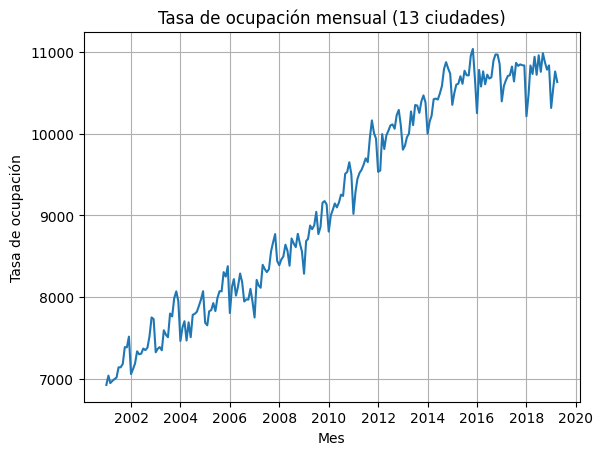

In [223]:
# imprimiendo el tamano del dataframe
print(ds_ocupados.shape)

# Graficando los datos
plt.title("Tasa de ocupación mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Tasa de ocupación")
plt.plot(ds_ocupados)
plt.grid()
plt.show()

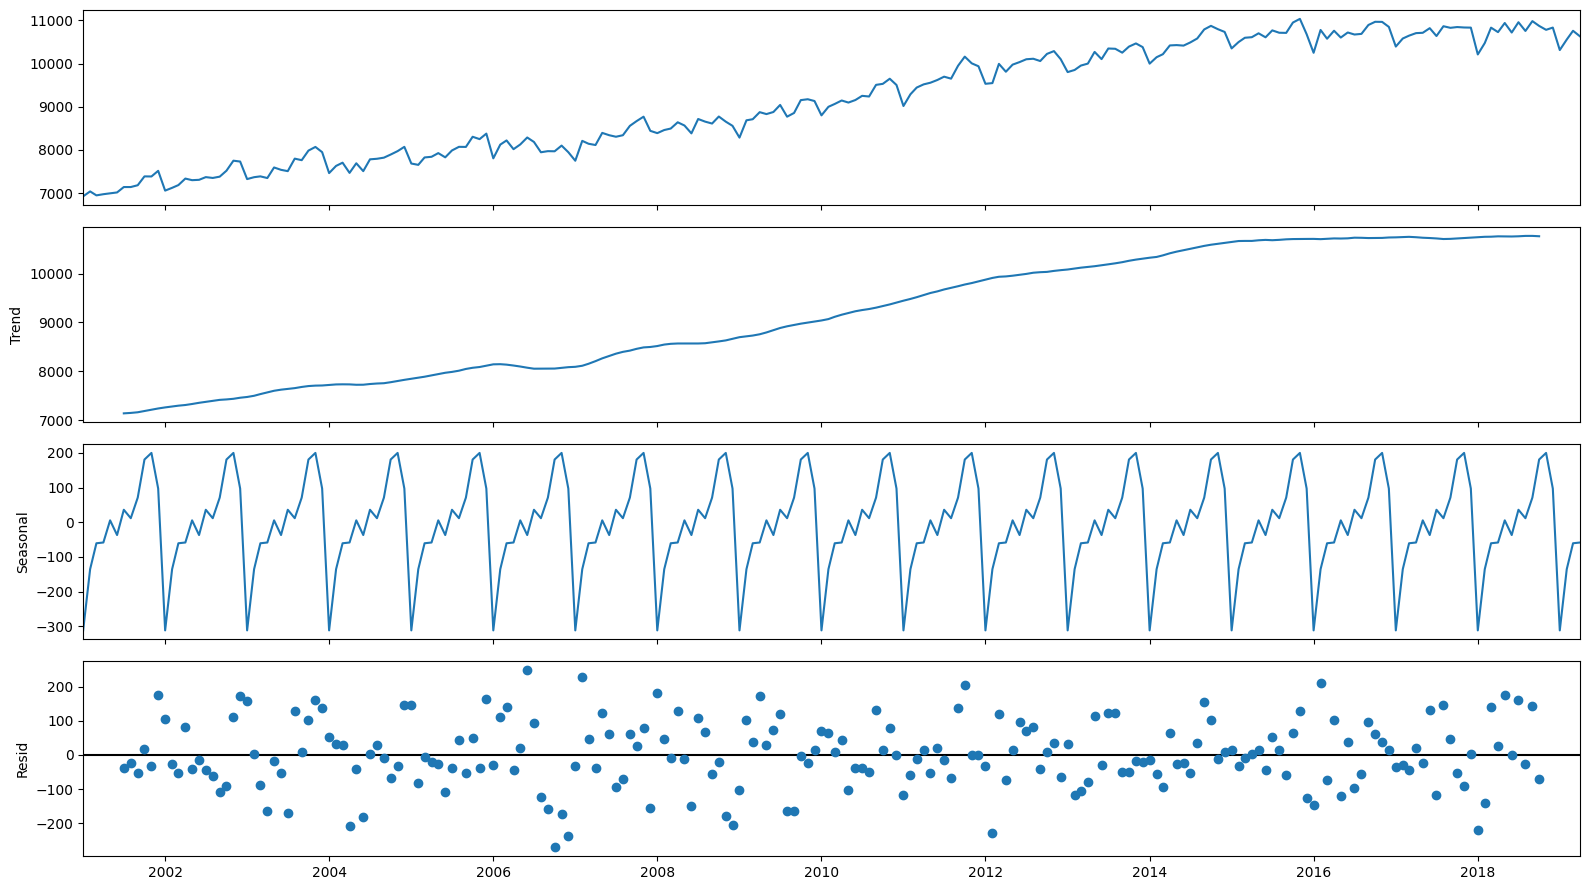

In [224]:
#@title 3. Encontrando los componentes de una serie de tiempo
td_componentes = seasonal_decompose(ds_ocupados,model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

In [226]:
td_componentes.seasonal

,seasonal
mes,
2001-01-01,-311.454885
2001-02-01,-135.216366
2001-03-01,-60.470657
2001-04-01,-58.270721
2001-05-01,5.551095
...,...
2018-12-01,97.140345
2019-01-01,-311.454885
2019-02-01,-135.216366


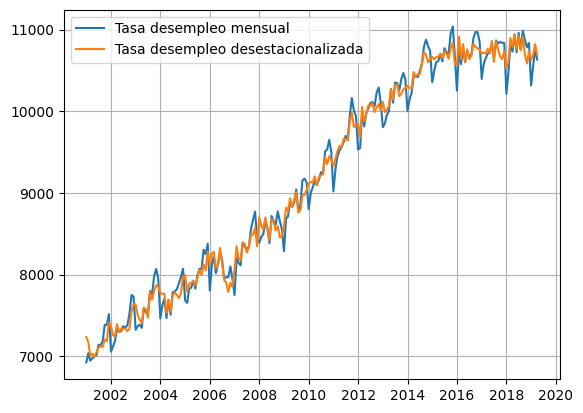

In [227]:
#td_desestacionalizada: Esta variable almacenará los datos de series temporales desestacionalizadas.
#data["Ocupados"]: Accede a la columna 'Ocupados' del data DataFrame, que representa los datos de empleo originales.
#td_componentes.seasonal: Accede al componente estacional extraído de la descomposición de series temporales realizada anteriormente y almacenado en td_componentes.
#La resta (-) elimina el componente estacional de los datos originales, lo que da como resultado datos desestacionalizados.

td_desestacionalizada = data["Ocupados"]-td_componentes.seasonal

plt.plot(data[["Ocupados"]],label="Tasa desempleo mensual")
plt.plot(td_desestacionalizada,label="Tasa desempleo desestacionalizada")
plt.legend()
plt.grid()
plt.show()

## **4. Pronosticando metodos de suavización**

Antes de continuar es importante guardar una parte de la muestra para evaluar el comportamiento de los modelos por fuera de muestra (out-of-sample). Guardemos un año de datos.

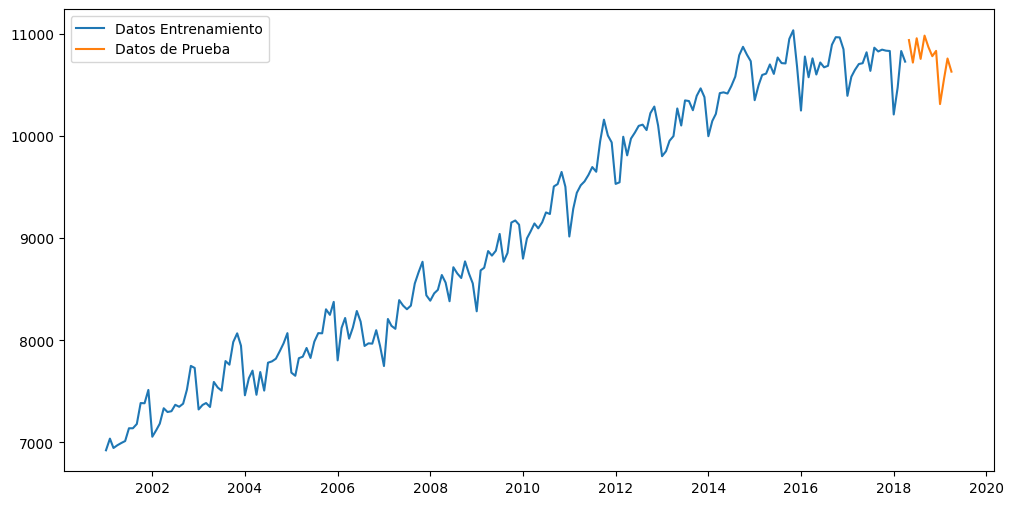

In [178]:
train_len = 208 #'''int(ds_ocupados.shape[0] * 0.95)'''
train_td = data[["Ocupados"]][:train_len]
test_td = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()


In [179]:
train_td.describe().T

,count,mean,std,min,25%,50%,75%,max
Ocupados,208.0,9052.532716,1266.050223,6923.604,7946.3435,8876.496,10303.5155,11037.199


In [180]:
test_td.describe().T

,count,mean,std,min,25%,50%,75%,max
Ocupados,12.0,10760.11175,190.62489,10314.438,10698.7165,10772.0375,10891.077,10984.928


In [181]:
train_td

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2017-12-01,10834.330
2018-01-01,10212.612
2018-02-01,10476.311


In [182]:
test_td

,Ocupados
mes,
2018-05-01,10941.294
2018-06-01,10720.946
2018-07-01,10959.197
2018-08-01,10756.782
2018-09-01,10984.928
2018-10-01,10874.338
2018-11-01,10783.299
2018-12-01,10835.398
2019-01-01,10314.438


#4.1 Promedio movil

In [183]:
## Considerando el dato actual
ma_2= train_td.rolling(2,min_periods=2).mean()
ma_3= train_td.rolling(3,min_periods=2).mean()
ma_4= train_td.rolling(4,min_periods=2).mean()
ma_5= train_td.rolling(5,min_periods=2).mean()

In [184]:
## Sin considerar el dato actual
ma_2= train_td.shift().rolling(2,min_periods=2).mean()
ma_3= train_td.shift().rolling(3,min_periods=2).mean()
ma_4= train_td.shift().rolling(4,min_periods=2).mean()
ma_5= train_td.shift().rolling(5,min_periods=2).mean()

In [185]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [186]:
ma_2_f= fore_ma(train_td,2,12)
ma_3_f= fore_ma(train_td,3,12)
ma_4_f= fore_ma(train_td,4,12)
ma_5_f= fore_ma(train_td,5,12)

In [187]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_td,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_td,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_td,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_td,ma_5_f ))

In [188]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

180.61405651284463 190.8075001193029 218.76010738130725 221.86244433696749


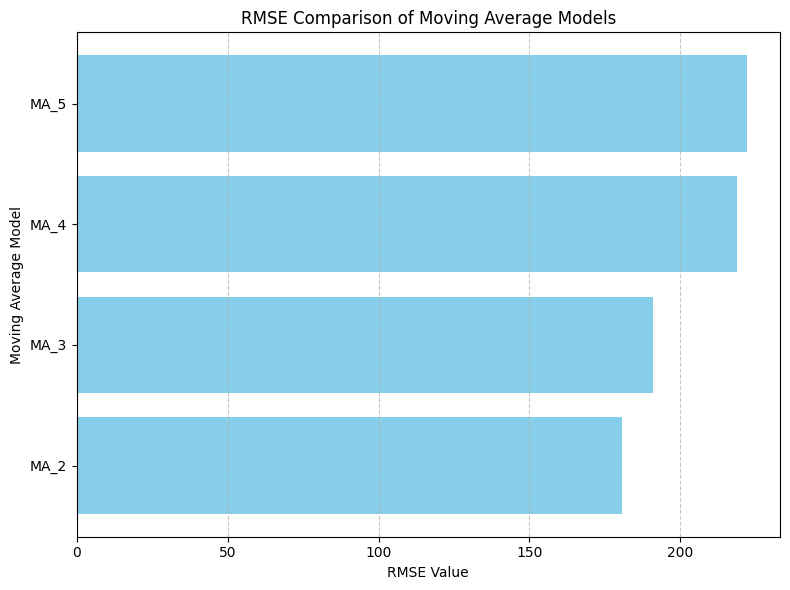

In [189]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Data (replace with your actual rmse values)
rmse_data = {
    'RMSE': [rmse_ma_2, rmse_ma_3, rmse_ma_4, rmse_ma_5],
    'Model': ['MA_2', 'MA_3', 'MA_4', 'MA_5']
}
rmse_df = pd.DataFrame(rmse_data)

# Horizontal bar plot
plt.figure(figsize=(8, 6))
plt.barh(rmse_df['Model'], rmse_df['RMSE'], color='skyblue')
plt.xlabel('RMSE Value')
plt.ylabel('Moving Average Model')
plt.title('RMSE Comparison of Moving Average Models')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

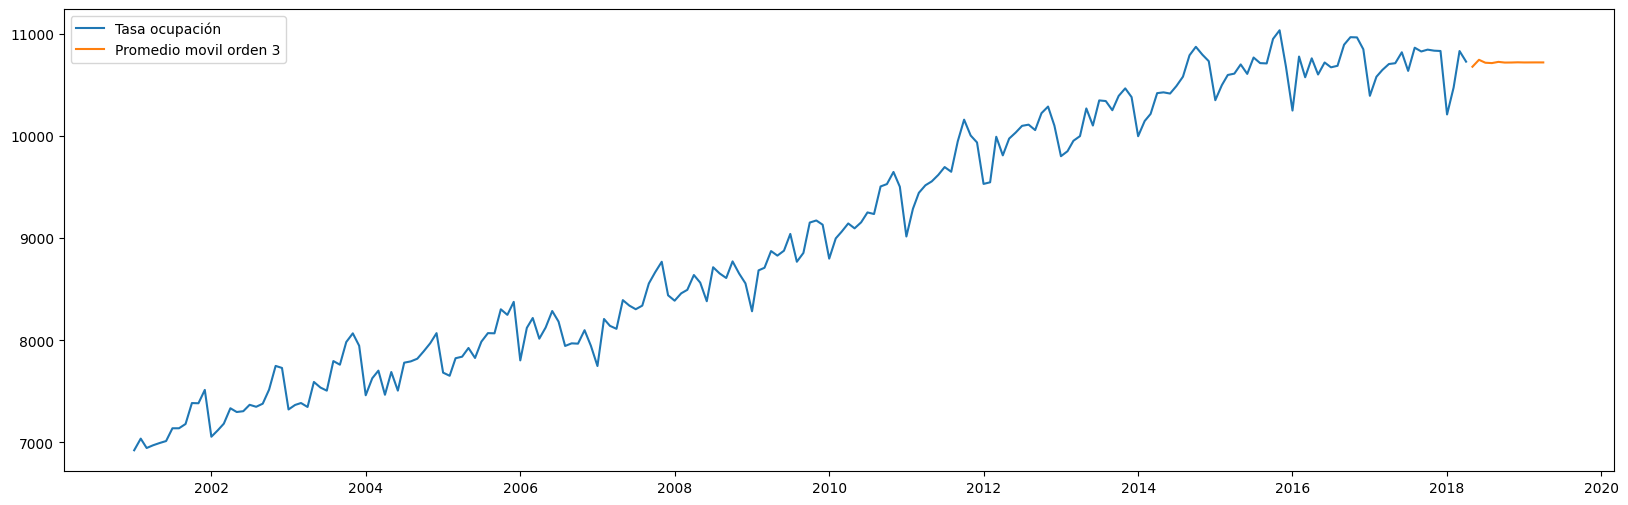

In [190]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Tasa ocupación")
plt.plot(ma_3_f,label="Promedio movil orden 3")
plt.legend(loc='upper left')
plt.show()

### **4.2 Suavizacion Exponencial Simple**


In [191]:
# Build model.
ets_model = ETSModel(endog=train_td["Ocupados"],error="add")#,trend="add",seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
(preds)

,Point_forecast,lower_95,upper_95
2018-05-01,10720.369929,10363.684215,11077.055642
2018-06-01,10720.369929,10295.289386,11145.450471
2018-07-01,10720.369929,10236.466801,11204.273056
2018-08-01,10720.369929,10184.057514,11256.682343
2018-09-01,10720.369929,10136.332451,11304.407406
2018-10-01,10720.369929,10092.223016,11348.516842
2018-11-01,10720.369929,10051.014034,11389.725823
2018-12-01,10720.369929,10012.198987,11428.540870
2019-01-01,10720.369929,9975.403586,11465.336271
2019-02-01,10720.369929,9940.341967,11500.397890


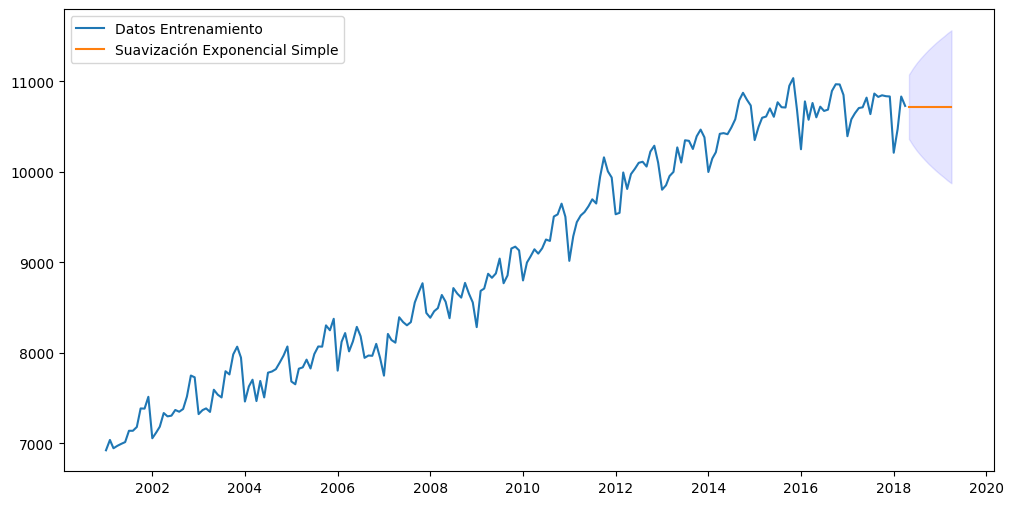

In [192]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

In [193]:
ses_rmse = np.sqrt(mean_squared_error(test_td,point_forecast ))
ses_alpha = ets_result.alpha
print(ses_rmse)
print(ses_alpha)

186.78626001062813
0.64828262016549


In [194]:
print(f"En esta caso el α estimado es {ses_alpha} .Y el RMSE en la muestra de evaluación es {ses_rmse}")

En esta caso el α estimado es 0.64828262016549 .Y el RMSE en la muestra de evaluación es 186.78626001062813


### **4.3 Suavizacion Exponencial Lineal (Holt)**

In [195]:
# Build model.
ets_model = ETSModel(endog=train_td["Ocupados"],error="mul",trend="mul")#,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
(preds_holt)

,Point_forecast,lower_95,upper_95
2018-05-01,10749.538883,10340.938278,11164.907442
2018-06-01,10773.218975,10334.984417,11206.984253
2018-07-01,10796.951232,10289.055872,11301.833700
2018-08-01,10820.735768,10223.974653,11378.682746
2018-09-01,10844.572699,10211.288863,11482.933995
2018-10-01,10868.462141,10205.465609,11563.000528
2018-11-01,10892.404208,10204.015832,11590.099008
2018-12-01,10916.399017,10160.238535,11664.092121
2019-01-01,10940.446684,10127.900664,11713.255659
2019-02-01,10964.547326,10113.828593,11820.057281


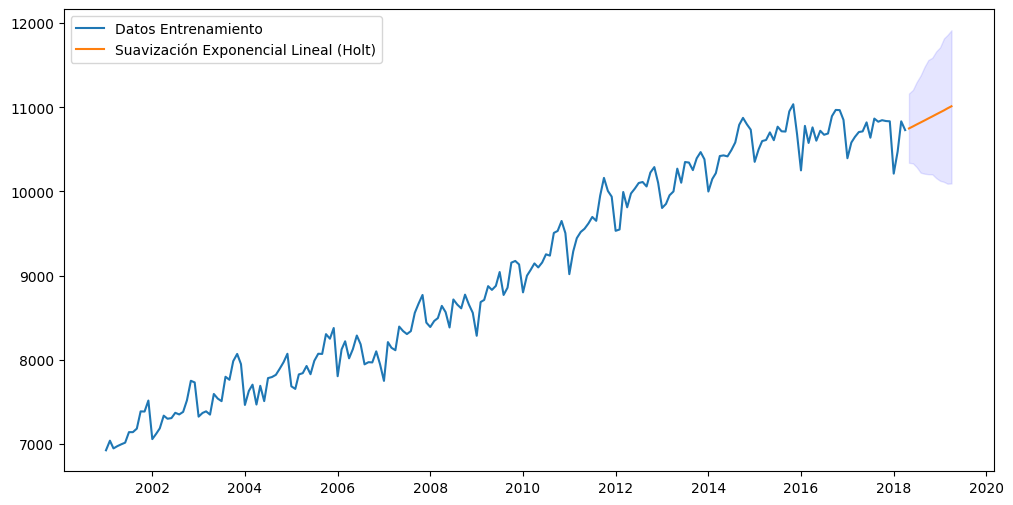

In [196]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

In [197]:
rmse_holt = np.sqrt(mean_squared_error(test_td,preds_holt['Point_forecast']))
print(rmse_holt)

268.07492885990695


In [198]:
sel_holt_alpha = ets_result.alpha
sel_holt_beta = ets_result.beta
print(ets_result.alpha,ets_result.beta)
print(f"En esta caso el α estimado es {sel_holt_alpha} y el β estimado es {sel_holt_beta} . Y el RMSE en la muestra de evaluación es {rmse_holt}.")

0.5619350383434504 5.619350383434504e-05
En esta caso el α estimado es 0.5619350383434504 y el β estimado es 5.619350383434504e-05 . Y el RMSE en la muestra de evaluación es 268.07492885990695.


## **4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

###"Suavización Exponencial Lineal (Holt-Winters) Aditivo"

In [199]:
ets_model = ETSModel(endog=train_td["Ocupados"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
(preds_hw_add)

,Point_forecast,lower_95,upper_95
2018-05-01,10798.400903,10576.753335,11020.048472
2018-06-01,10786.645311,10536.711164,11036.579458
2018-07-01,10864.222813,10588.888146,11139.557480
2018-08-01,10870.075531,10571.488948,11168.662115
2018-09-01,10934.690701,10614.532325,11254.849076
2018-10-01,11077.997076,10737.627438,11418.366715
2018-11-01,11113.088752,10753.638804,11472.538701
2018-12-01,11027.773060,10650.202260,11405.343861
2019-01-01,10640.970865,10246.106556,11035.835174
2019-02-01,10832.497382,10421.062569,11243.932196


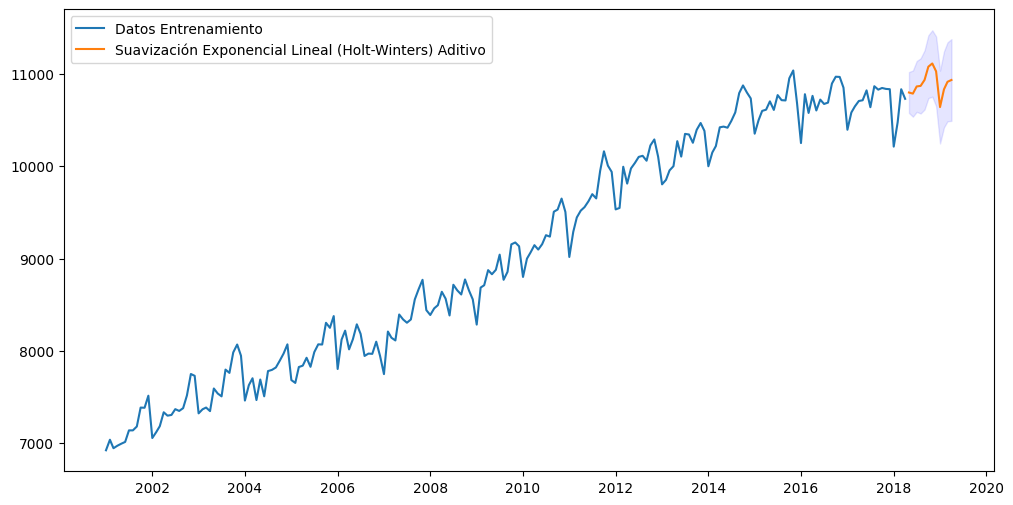

In [200]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

In [201]:
sel_winter_alpha = ets_result.alpha,
sel_winter_beta = ets_result.beta,
sel_winter_gamma  = ets_result.gamma
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.5210294726964335 5.210294726964335e-05 4.7897052730356654e-05


In [202]:
rmse_hw_add = np.sqrt(mean_squared_error(test_td,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

210.80972716286084


In [203]:
print(f"En esta caso el α estimado es {sel_winter_alpha}, el β estimado es {sel_winter_beta}, el γ estimado es {sel_winter_gamma}. Y el RMSE en la muestra de evaluación es {rmse_hw_add}.")

En esta caso el α estimado es (0.5210294726964335,), el β estimado es (5.210294726964335e-05,), el γ estimado es 4.7897052730356654e-05. Y el RMSE en la muestra de evaluación es 210.80972716286084.


##"Suavización Exponencial Lineal (Holt-Winters) Multiplicativo"

In [204]:

ets_model = ETSModel(endog=train_td["Ocupados"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(12)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
(preds_hw_mul)

,Point_forecast,lower_95,upper_95
2018-05-01,10787.445073,10579.536966,11018.552824
2018-06-01,10757.065081,10504.423724,11029.411953
2018-07-01,10832.085926,10531.940954,11127.360515
2018-08-01,10816.529688,10500.487303,11172.172753
2018-09-01,10878.550605,10512.148103,11230.666772
2018-10-01,11021.781178,10630.680213,11397.566643
2018-11-01,11036.623585,10600.886036,11427.917722
2018-12-01,10910.527801,10462.944489,11342.124424
2019-01-01,10434.470189,9974.058549,10886.019292
2019-02-01,10638.037808,10196.474247,11115.509819


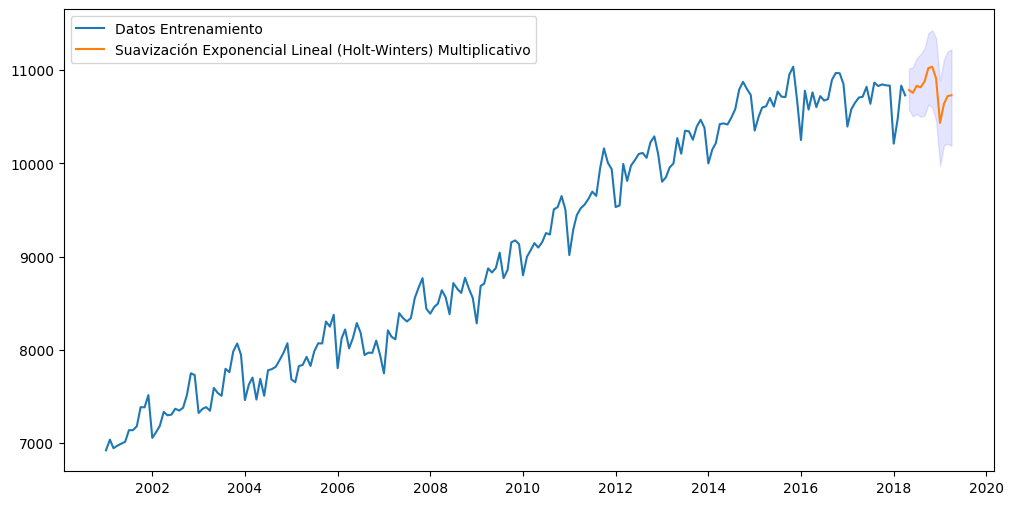

In [205]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend(loc='upper left')
plt.show()

In [212]:
sel_hwintermul_alpha = ets_result.alpha,
sel_hwintermul_gamma  = ets_result.gamma
print(ets_result.alpha,ets_result.gamma)

0.6067561515082243 3.9324384849177576e-05


In [220]:
rmse_hwinter_mul = np.sqrt(mean_squared_error(test_td,preds_hw_mul['Point_forecast']))
print(rmse_hwinter_mul)


236.27733521507758


In [221]:
print(f"En esta caso el α estimado es {sel_wintermul_alpha}  el γ estimado es {sel_wintermul_gamma}. Y el RMSE en la muestra de evaluación es {rmse_hwinter_mul}.")

En esta caso el α estimado es (0.5221179763142122,)  el γ estimado es 4.778820236857878e-05. Y el RMSE en la muestra de evaluación es 236.27733521507758.
